In [2]:
!apt-get update
!apt-get install git

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:2 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency 

In [3]:
!git clone https://github.com/Hamster-yang/ai_captcha.git

Cloning into 'ai_captcha'...
remote: Enumerating objects: 211483, done.
remote: Counting objects: 100% (30103/30103), done.
remote: Compressing objects: 100% (30079/30079), done.
remote: Total 211483 (delta 40), reused 30084 (delta 23), pack-reused 181380
Receiving objects: 100% (211483/211483), 230.87 MiB | 17.57 MiB/s, done.
Resolving deltas: 100% (104/104), done.
Checking out files: 100% (62180/62180), done.


In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import random

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Layer, BatchNormalization 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model, Input 
from tensorflow.keras.callbacks import EarlyStopping

import plotly.express as px
import plotly.graph_objects as go

import os

In [9]:
import string
captcha_list = []
img_shape = (30, 120, 1)
symbols = string.ascii_lowercase+ string.ascii_uppercase + "0123456789"

len_symbols = len(symbols) # the number of symbols
nSamples = len(os.listdir('/content/ai_captcha/train')) # the number of samples 'captchas'
len_captcha = 5

X = np.zeros((nSamples, 30, 120, 1)) # 1070 * 50 * 200
y = np.zeros((5, nSamples, len_symbols)) # 5 * 1070 * 36

nSamples_test = len(os.listdir('/content/ai_captcha/test')) # the number of samples 'captchas'

X_test1 = np.zeros((nSamples_test, 30, 120, 1)) # 1070 * 50 * 200
y_test1 = np.zeros((5, nSamples_test, len_symbols)) # 5 * 1070 * 36

In [ ]:
symbols

'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'

In [10]:
for i, captcha in enumerate(os.listdir('/content/ai_captcha/train')):
    captcha_code = captcha.split(".")[0]
    captcha_list.append(captcha_code)
    captcha_cv2 = cv2.imread(os.path.join('/content/ai_captcha/train', captcha), cv2.IMREAD_GRAYSCALE)

        
    captcha_cv2=cv2.resize(captcha_cv2,[300,100])
    kernel = np.ones((3,3), np.uint8)
    captcha_cv2=cv2.dilate(captcha_cv2,kernel,iterations = 1)
    ret,captcha_cv2=cv2.threshold(captcha_cv2,195,255,cv2.THRESH_BINARY)

    captcha_cv2=cv2.resize(captcha_cv2,[120,30])
    
    captcha_cv2 = captcha_cv2 / 255.0
    captcha_cv2 = np.reshape(captcha_cv2, img_shape)
    targs = np.zeros((len_captcha, len_symbols))
    
    for a, b in enumerate(captcha_code):
        targs[a, symbols.index(b)] = 1
    
    X[i] = captcha_cv2
    y[:, i] = targs

In [11]:
for i, captcha in enumerate(os.listdir('/content/ai_captcha/test')):
    captcha_code = captcha.split(".")[0]
    captcha_list.append(captcha_code)
    captcha_cv2 = cv2.imread(os.path.join('/content/ai_captcha/test', captcha), cv2.IMREAD_GRAYSCALE)

        
    captcha_cv2=cv2.resize(captcha_cv2,[300,100])
    kernel = np.ones((3,3), np.uint8)
    captcha_cv2=cv2.dilate(captcha_cv2,kernel,iterations = 1)
    ret,captcha_cv2=cv2.threshold(captcha_cv2,195,255,cv2.THRESH_BINARY)

    captcha_cv2=cv2.resize(captcha_cv2,[120,30])
    
    captcha_cv2 = captcha_cv2 / 255.0
    captcha_cv2 = np.reshape(captcha_cv2, img_shape)
    targs = np.zeros((len_captcha, len_symbols))
    
    for a, b in enumerate(captcha_code):
        targs[a, symbols.index(b)] = 1
    
    X_test1[i] = captcha_cv2
    y_test1[:, i] = targs

In [12]:
print("shape of X:", X.shape)
print("shape of y:", y.shape)
print("shape of X_test1:", X_test1.shape)
print("shape of y_test1:", y_test1.shape)

shape of X: (10000, 30, 120, 1)
shape of y: (5, 10000, 62)
shape of X_test1: (20000, 30, 120, 1)
shape of y_test1: (5, 20000, 62)


In [13]:
X_train = X[:10000] 
y_train = y[:, :10000]
X_test = X_test1[:20000]
y_test = y_test1[:, :20000]

In [14]:
captcha = Input(shape=(30,120,1))
x = Conv2D(16, (3,3),padding='same',activation='relu')(captcha)
x = MaxPooling2D((2,2) , padding='same')(x)
x = Conv2D(32, (3,3),padding='same',activation='relu')(x)
x = MaxPooling2D((2,2) , padding='same')(x)
x = Conv2D(32, (3,3),padding='same',activation='relu')(x)
x = MaxPooling2D((2,2) , padding='same')(x)
x = Conv2D(32, (3,3),padding='same',activation='relu')(x)
x = MaxPooling2D((2,2) , padding='same')(x)
x = BatchNormalization()(x)


flatOutput = Flatten()(x)

dense1 = Dense(64 , activation='relu')(flatOutput)
dropout1= Dropout(0.5)(dense1)
output1 = Dense(len_symbols , activation='sigmoid' , name='char_1')(dropout1)

dense2 = Dense(64 , activation='relu')(flatOutput)
dropout2= Dropout(0.5)(dense2)
output2 = Dense(len_symbols , activation='sigmoid' , name='char_2')(dropout2)
    
dense3 = Dense(64 , activation='relu')(flatOutput)
dropout3= Dropout(0.5)(dense3)
output3 = Dense(len_symbols , activation='sigmoid' , name='char_3')(dropout3)
    
dense4 = Dense(64 , activation='relu')(flatOutput)
dropout4= Dropout(0.5)(dense4)
output4 = Dense(len_symbols , activation='sigmoid' , name='char_4')(dropout4)
    
dense5 = Dense(64 , activation='relu')(flatOutput)
dropout5= Dropout(0.5)(dense5)
output5 = Dense(len_symbols , activation='sigmoid' , name='char_5')(dropout5)
    
model = Model(inputs = captcha , outputs=[output1 , output2 , output3 , output4 , output5])

In [15]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
earlystopping = EarlyStopping(monitor ="val_loss",  
                             mode ="min", patience = 5,  
                             restore_best_weights = True) 

history = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]], batch_size=16, epochs=240, verbose=1, validation_split=0.2 )#callbacks =[earlystopping])

Epoch 1/240
500/500 [==============================] - 14s 10ms/step - loss: 20.6379 - char_1_loss: 4.1263 - char_2_loss: 4.1257 - char_3_loss: 4.1277 - char_4_loss: 4.1277 - char_5_loss: 4.1304 - char_1_accuracy: 0.0255 - char_2_accuracy: 0.0247 - char_3_accuracy: 0.0241 - char_4_accuracy: 0.0211 - char_5_accuracy: 0.0246 - val_loss: 20.5374 - val_char_1_loss: 4.1085 - val_char_2_loss: 4.1034 - val_char_3_loss: 4.1080 - val_char_4_loss: 4.1100 - val_char_5_loss: 4.1075 - val_char_1_accuracy: 0.0275 - val_char_2_accuracy: 0.0335 - val_char_3_accuracy: 0.0280 - val_char_4_accuracy: 0.0160 - val_char_5_accuracy: 0.0325
Epoch 2/240
500/500 [==============================] - 5s 9ms/step - loss: 20.5097 - char_1_loss: 4.1013 - char_2_loss: 4.0996 - char_3_loss: 4.1030 - char_4_loss: 4.1043 - char_5_loss: 4.1015 - char_1_accuracy: 0.0331 - char_2_accuracy: 0.0331 - char_3_accuracy: 0.0305 - char_4_accuracy: 0.0279 - char_5_accuracy: 0.0345 - val_loss: 20.4863 - val_char_1_loss: 4.0967 - val_

In [16]:
score = model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]],verbose=1)

print('Test Loss and accuracy:', score)

625/625 [==============================] - 5s 7ms/step - loss: 3.6588 - char_1_loss: 0.2860 - char_2_loss: 0.6142 - char_3_loss: 1.2102 - char_4_loss: 1.1017 - char_5_loss: 0.4467 - char_1_accuracy: 0.9499 - char_2_accuracy: 0.9021 - char_3_accuracy: 0.8177 - char_4_accuracy: 0.7774 - char_5_accuracy: 0.9047
Test Loss and accuracy: [3.6588215827941895, 0.28599393367767334, 0.6141571402549744, 1.2102302312850952, 1.101743221282959, 0.4466981589794159, 0.9499499797821045, 0.9021499752998352, 0.8177000284194946, 0.7773500084877014, 0.9047499895095825]


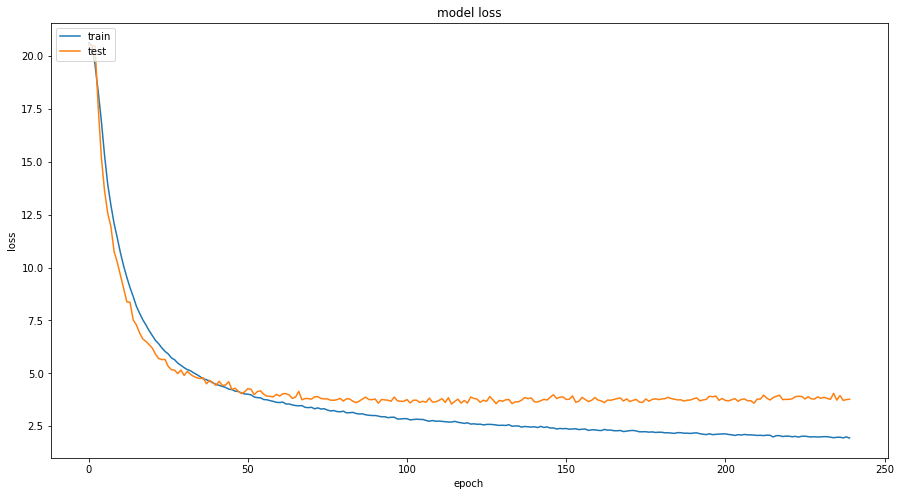

In [17]:
plt.figure(figsize=(15,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
def makePredict(captcha):
    captcha = np.reshape(captcha , (30,120))
    result = model.predict(np.reshape(captcha, (1,30,120,1)))
    result = np.reshape(result ,(5,62))
    indexes =[]
    for i in result:
        indexes.append(np.argmax(i))
        
    label=''
    for i in indexes:
        label += symbols[i]
        
    return label

In [18]:
def predict(filepath):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

    img=cv2.resize(img,[300,100])
    kernel = np.ones((3,3), np.uint8)
    img=cv2.dilate(img,kernel,iterations = 1)
    ret,img=cv2.threshold(img,195,255,cv2.THRESH_BINARY)

    img=cv2.resize(img,[120,30])


    if img is not None:
        img = img / 255.0
    else:
        print("Not detected")
        return '100000'
    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis]))
    ans = np.reshape(res, (5, 62))#-------------------------------------------------------
    l_ind = []
    probs = []
    for a in ans:
        l_ind.append(np.argmax(a))
        #probs.append(np.max(a))

    capt = ''
    for l in l_ind:
        capt += symbols[l]
    return capt#, sum(probs) / 5

In [ ]:
image = cv2.imread("/content/ai_captcha/test/OoqzD.png", cv2.IMREAD_GRAYSCALE)

# 使用自適應閾值法對圖像進行二值化
thresholded_image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 3, 1)

# 顯示原圖和二值化後的圖像
plt.imshow(image,cmap='gray')
plt.show()

plt.imshow(thresholded_image,cmap='gray')
plt.show()

In [ ]:
image = cv2.imread("/content/ai_captcha/test/00utJ.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image,cmap='gray')
plt.show()
image=cv2.resize(image,[300,100])
kernel = np.ones((3,3), np.uint8)
image=cv2.dilate(image,kernel,iterations = 1)
ret,image=cv2.threshold(image,195,255,cv2.THRESH_BINARY)

image1=cv2.resize(image,[120,30])
plt.imshow(image1,cmap='gray')

plt.show()

In [ ]:
# rwyT4 d97Tm xn6j0 9hj5I QBsJp

In [19]:
while(1):
    str_path ="/content/ai_captcha/test/" + input("path:")+ ".png"
    if str_path == '/content/ai_captcha/test/qqq.png':
        break
    str=predict(str_path)
    if str != '100000' :

        print(str)

path:4TaAc
1/1 [==============================] - 0s 243ms/step
4TaAc
path:Y5zBR
1/1 [==============================] - 0s 16ms/step
Y5zSR
path:ErZji
1/1 [==============================] - 0s 17ms/step
EnZji
path:sUa5K
1/1 [==============================] - 0s 16ms/step
sUa5K
path:1wYFj
1/1 [==============================] - 0s 16ms/step
1wYTj
path:kzryy
1/1 [==============================] - 0s 17ms/step
kzryy
path:hWSUp
1/1 [==============================] - 0s 17ms/step
hWSUp
path:qqq


In [20]:
model.save('model_v5_1.h5')